In [1]:
#This code is the pipeline for plotting the PCA maps and doing some sample selection.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
import marvin
from marvin.tools.image import Image
from marvin.utils.general.images import showImage
from marvin.tools.maps import Maps
from marvin.tools.quantities.map import Map
import marvin.utils.plot.map as mapplot
import pdb
from matplotlib import colors
import math
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as c
import pickle
import os
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.path import Path
from pathlib import Path as filepath
from MaNGA_Utils import spx_map
from VW_PCA import VW_PCA

vwPca = VW_PCA()

#from sdss_access import RsyncAccess
#rsync = RsyncAccess()
#rsync.remote()

from marvin import config

release = 'DR17'

# by default the mode is set to 'auto', but let's set it explicitly to local/remote.
#config.mode = 'auto'
#config.download = True
##config.access = 'collab' #'public'
config.setRelease(release)

# login to receive a token
#config.login(refresh=True)

# see token
#config.token
#print(config.access, config.release)

if (release=='DR15'):
    release='MPL-7'
print(release)

dir = '/Users/krowlands/work/Science/MaNGA/'
fig_dir = dir+'FIGS/'+release+'/'

label_size = 16
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['axes.labelsize'] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DR17


In [5]:
#Open cat
if (release=='MPL-7'):
    drpallfile = 'drpall-v2_4_3_gals.fits'
if (release=='MPL-8'):
    drpallfile = 'drpall-v2_5_3.fits'
if (release=='DR17'):
    drpallfile = 'drpall-v3_1_1.fits'
    
cat = fits.open(dir+'DATA/'+release+'/'+drpallfile)
tbdata = cat[1].data
cat.close()
    
#Remove bad IFUs with critical flags, potential bad things. Missing DAP maps will be skipped in the loop.
ind_good = np.where((tbdata.field('DRP3QUAL') < 20000) & (tbdata.field('nsa_z') > 0.) & \
                    (tbdata.field('nsa_elpetro_th50_r') > 0.) )

#DAPQUAL also check this https://trac.sdss.org/wiki/MANGA/TRM/TRM_ActiveDev/DAPMetaData#Maskbits

mangaid = np.array(tbdata.field('mangaid')[ind_good])
nsa_id = np.array(tbdata.field('NSA_NSAID')[ind_good])
plateifu = tbdata.field('plateifu')[ind_good]
plate = tbdata.field('plate')[ind_good]
ifu = tbdata.field('ifudsgn')[ind_good]
z = tbdata.field('nsa_z')[ind_good]
ra = tbdata.field('objra')[ind_good]
dec = tbdata.field('objdec')[ind_good]
ra_plate = tbdata.field('ifura')[ind_good]
dec_plate = tbdata.field('ifudec')[ind_good]
petro_r_50 = tbdata.field('nsa_elpetro_th50_r')[ind_good]
nsa_elpetro_ba = tbdata.field('nsa_elpetro_ba')[ind_good]
nsa_elpetro_phi = tbdata.field('nsa_elpetro_phi')[ind_good]
nsa_elpetro_mass = tbdata.field('nsa_elpetro_mass')[ind_good]
nsa_elpetro_mass_log = np.log10(nsa_elpetro_mass)
ebvgal = tbdata.field('ebvgal')[ind_good]
nsa_sersic_n = tbdata.field('nsa_sersic_n')[ind_good]
nsa_elpetro_absmag = tbdata.field('nsa_elpetro_absmag')[ind_good]
nsa_elpetro_absmag_r = nsa_elpetro_absmag[4]

cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
distance = cosmo.luminosity_distance(z) #Mpc
angular_diameter_distance = cosmo.arcsec_per_kpc_comoving(z) #arcsec / kpc
arc2pc = 1000./angular_diameter_distance.value #area of each spaxel in pc

spaxel_size = 0.5 # "/pix pixel_scale
spaxel_area = (spaxel_size / np.array(angular_diameter_distance))**2 #kpc^2
ngal = len(plateifu)
print(ngal)

MaNGA_HYB10_dir = dir+'DATA/'+release+'/'

10124


In [6]:
petro_frac_out = np.array([2.])

ellip_ap_radius_as_out_major = petro_r_50 / petro_frac_out  #arcsec

ellip_ap_radius_pix_out_major = ellip_ap_radius_as_out_major / spaxel_size #arcsec -> pix
ellip_ap_radius_pix_out_minor = nsa_elpetro_ba * ellip_ap_radius_pix_out_major #Axis ratio b/a

theta_rad = np.radians(nsa_elpetro_phi-90) #radians - use for getAperture in pixel coords
theta = nsa_elpetro_phi #deg - use for getAperture in sky coords
#The rotation angle in radians of the semimajor axis from the
#positive x axis. The rotation angle increases counterclockwise.
#nsa_elpetro_phi is Angle (E of N) - needs -90 to make the right way up.

In [7]:
#PCA boundaries
vertices_lowmass = {
"psb_cut":0.24, \
"psb_cut2":-0.4, \
"psb_cut3":-0.1, \
"psb_peak_x":-4.7, \
"sb_cut":0.15, \
"sb_vert1":-2.3, \
"sf_vert1":-6.3, \
"sf_vert2":-5.5, \
"sf_vert3":-2.6, \
"sf_vert4":-3.2, \
"green_vert1": -1.0, \
"green_vert2": -2.1, \
"junk_y_lower": -1.4, \
"junk_y_lower2": -3., \
"junk_y_upper": 2., \
"left_cut": -7.1, \
"right_cut": 2., \
}

vertices_highmass = {
"psb_cut":0.24, \
"psb_cut2":0.18, \
"psb_cut3":0.2, \
"psb_peak_x":-4.7, \
"sb_cut":0.0, \
"sb_vert1":-1.9, \
"sf_vert1":-5.5, \
"sf_vert2":-5.2, \
"sf_vert3":-2.2-0.07, \
"sf_vert4":-3.2-0.07, \
"green_vert1": -0.1, \
"green_vert2": -2.0-0.07, \
"junk_y_lower": -1.2, \
"junk_y_lower2": -3., \
"junk_y_upper": 2., \
"left_cut": -7.1-0.07, \
"right_cut": 2., \
}

In [8]:
#Read in results files for all spaxels
spaxel_properties_master = pickle.load( open( dir+'PCA_results_DR17_fits/spaxel_properties_master_'+release+'.p', "rb" ) )
[total_spaxels_ell, red_spaxels_ell, blue_spaxels_ell, sb_spaxels_ell, green_spaxels_ell, \
            psb_spaxels_ell, red_frac_ell, blue_frac_ell, \
            sb_frac_ell, green_frac_ell, psb_frac_ell, total_spaxels_ell_all, masked_spaxels_ell, masked_frac_ell] = \
            pickle.load( open( dir+'PCA_results_DR17_fits/elliptical_radii_params_'+release+'.p', "rb" ) )

[WARNING]: unclosed file <_io.BufferedReader name='/Users/krowlands/work/Science/MaNGA/PCA_results_DR17_fits/spaxel_properties_master_DR17.p'> (ResourceWarning)
[WARNING]: unclosed file <_io.BufferedReader name='/Users/krowlands/work/Science/MaNGA/PCA_results_DR17_fits/elliptical_radii_params_DR17.p'> (ResourceWarning)


In [9]:
#Remove edge-on galaxies
highly_inclined = ascii.read(dir+'DATA/MPL-7/mpl7_highly_inclined.dat') #From Preethi Nair

nsa_id_highly_inclined = highly_inclined['nsa_id']

nsa_id_highly_edgeon = nsa_id_highly_inclined[highly_inclined['edge-on?']=='y'].data
nsa_id_highly_inclined = nsa_id_highly_inclined[highly_inclined['edge-on?']=='y'].data
highly_edgeon_indices = np.isin(nsa_id, nsa_id_highly_edgeon)
    
if ((release=='MPL-8') | (release=='DR17')):
    #Inspected by-eye by Kate Rowlands, just PLATEIFU
    edgon_extra = ascii.read(dir+'DATA/MPL-8/mpl8_highly_inclined.dat', format='commented_header')
    highly_edgeon_indices2 = np.isin(np.array(plateifu.astype(str, copy=False)), np.array(edgon_extra['plateifu']))

In [10]:
#Select galaxies based on central spaxel classifcation within an elliptical aperture

#8312-12701 Re is wrong. 
#Select out visually identified edge-on galaxies in PSB selection. Axis ratio didn't work too well.

select_psb = np.where((psb_frac_ell>=0.5) & (masked_frac_ell<0.5) & (plateifu!='8312-12701') & \
                      (highly_edgeon_indices==False) & \
                     (highly_edgeon_indices2==False) & \
                     (petro_r_50<50.) )
#These were excluded previously, I'm not sure why, check (might be edge-on).                
#& (plateifu!='8932-9102') & (plateifu!='8550-6102') & (plateifu!='7992-12701') &
                     #(plateifu!='8623-12703') & (plateifu!='9865-12701') )

psbs = plateifu[select_psb]
#print(psbs)
#print(psb_frac_ell[select_psb])
#print(total_spaxels_ell[select_psb])
print('PSB', len(psbs))

t1 = Table([psbs, np.round(psb_frac_ell[select_psb], 2)])
t1.rename_column('col0', 'PLATEIFU')
t1.rename_column('col1', 'psb_frac_ell') 
t1.write(dir+'DATA/'+release+'/psb_'+release+'.fits', format='fits', overwrite=True)


select_sb = np.where((sb_frac_ell>0.3) & (masked_frac_ell<0.5) & (plateifu!='8312-12701') & (petro_r_50<50.))# & (psb_frac_ell<0.3))
sb = plateifu[select_sb]
#print(sb_frac_ell[select_sb])
print('SB', len(sb))

t2 = Table([sb])
t2.rename_column('col0', 'PLATEIFU') 
t2.write(dir+'DATA/'+release+'/sb_'+release+'.fits', format='fits', overwrite=True)

select_sb_psb = np.hstack((select_psb[0], select_sb[0]))


select_sf = np.where((blue_frac_ell>0.3) & (masked_frac_ell<0.5) & (plateifu!='8312-12701') & (petro_r_50<50.) )
sf = plateifu[select_sf]
print('SF', len(sf))

t1 = Table([sf])
t1.rename_column('col0', 'PLATEIFU') 
t1.write(dir+'DATA/'+release+'/sf_'+release+'.fits', format='fits', overwrite=True)

select_q = np.where((red_frac_ell>0.3) & (masked_frac_ell<0.5) & (petro_r_50<50.) )
q = plateifu[select_q]
print('Q', len(q))

t1 = Table([q])
t1.rename_column('col0', 'PLATEIFU') 
t1.write(dir+'DATA/'+release+'/q_'+release+'.fits', format='fits', overwrite=True)

#All
t1 = Table([plateifu, np.round(psb_frac_ell, 2), np.round(blue_frac_ell, 2), np.round(sb_frac_ell, 2), \
            np.round(green_frac_ell, 2), np.round(red_frac_ell, 2), np.round(masked_frac_ell, 2)])
t1.rename_column('col0', 'PLATEIFU')
t1.rename_column('col1', 'psb_frac_ell') 
t1.rename_column('col2', 'sf_frac_ell') 
t1.rename_column('col3', 'sb_frac_ell')
t1.rename_column('col4', 'green_frac_ell') 
t1.rename_column('col5', 'red_frac_ell')
t1.rename_column('col6', 'masked_frac_ell') 
t1.write(dir+'DATA/'+release+'/all_frac_'+release+'.fits', format='fits', overwrite=True)

PSB 413
SB 61
SF 3791
Q 4371


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10213-9101


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10220-3703


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10220-6102


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10222-12703


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10223-12701


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10223-9101


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10223-9102


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10226-3703


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10226-6104


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10495-12703


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10498-6101


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10500-6101


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10501-1901


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10502-6104


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10504-9101


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10507-12704


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10507-1901


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10508-3704


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10508-9102


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10510-6103


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10511-12701


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10513-9101


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10515-3703


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10515-6102


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10515-6104


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10516-6103


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10518-3701


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10518-3704


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10518-6104


[WARNING]: showImage is deprecated as of Marvin 2.3.0. Please use marvin.tools.image.Image instead. (MarvinDeprecationWarning)


10520-6101


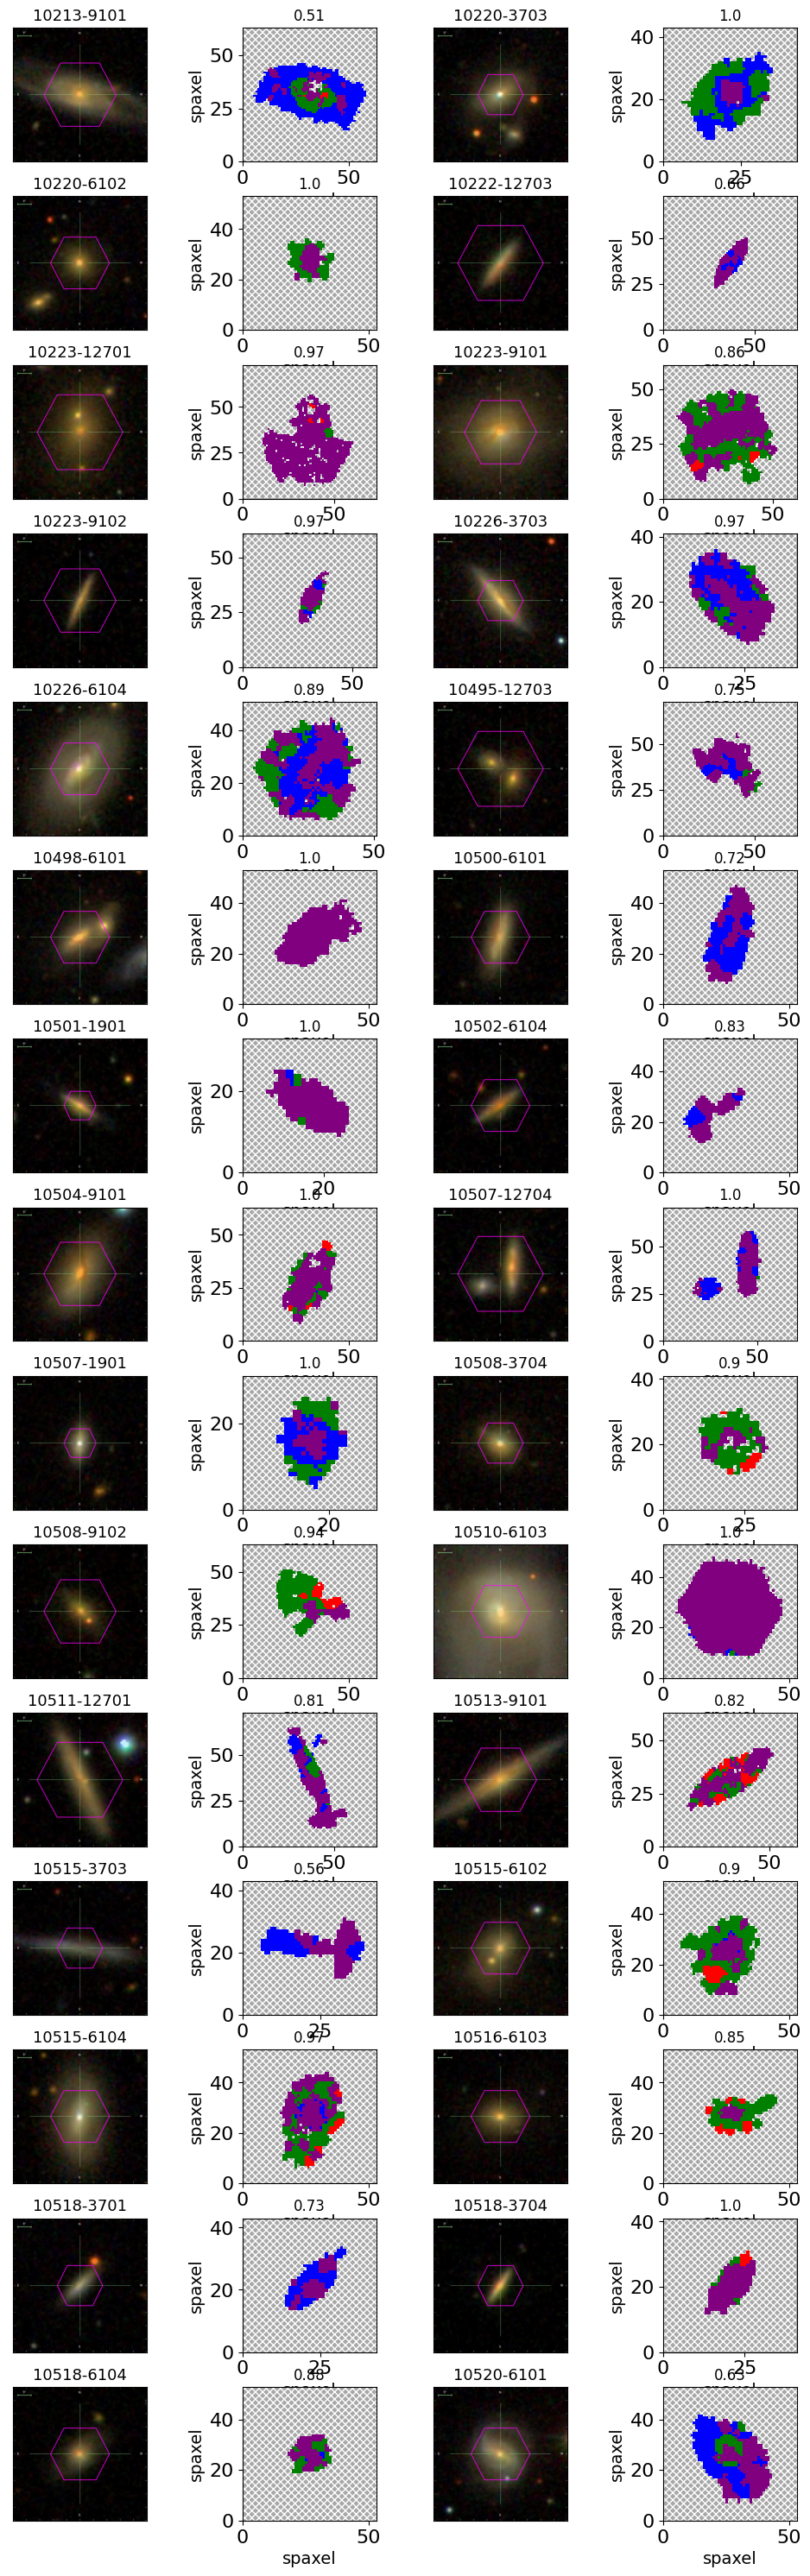

In [11]:
from matplotlib import colors

select = select_psb

n_select = 15
#n_select = int(len(plateifu[select])/2)+1 #Everything, will be slow/too large for n_select>20

# make a color map of fixed colors
cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
#bounds=[0,1,2,3,4,5,6]
#norm = colors.BoundaryNorm(bounds, cmap.N)

cols=4

fig, axs = plt.subplots(nrows=n_select, ncols=cols, figsize=(3*cols, 2.5*n_select))
fig.subplots_adjust(hspace=0.26, wspace=.22)

for i in range(n_select):
    for j in range(2):

        ind = select[0][(2*i+j)]
        
        print(plateifu[ind])
        
        #Plot SDSS image
        image = showImage(plateifu=plateifu[ind], show_image=False)
        img = axs[i, j*2].imshow(image)
        #Doesn't work #####
        #image = Image(plateifu=plateifu[ind])
        #img = axs[i, j*2].imshow(image)
        #axs[i, j*2] = image.plot(ax=axs[i, (j*2)+1])
        #######
        axs[i, j*2].set_title(str(plateifu[ind]), fontsize=13)
        axs[i, j*2].get_xaxis().set_visible(False) #Suppress tick labels
        axs[i, j*2].get_yaxis().set_visible(False)

        #Plot PCA class map
        my_file = filepath(dir+'PCA_results_'+release+'_fits/manga-'+plateifu[ind]+'_PCA.fits.gz')
        if my_file.is_file()==True:
            hdu = fits.open(dir+'PCA_results_'+release+'_fits/manga-'+plateifu[ind]+'_PCA.fits.gz')
            
            sfh_class = np.ma.MaskedArray(hdu['classmap'].data, mask=hdu['classmap'].data < 1) #Mask junk
            spx_bin_mask = hdu['spx_bin_mask'].data
            
            #Includes snr cut and bad spaxels
            PCA_SNR_masked = np.ma.MaskedArray(sfh_class, mask=hdu['qualmask'].data==1)

            #Define no coverage (edge of IFU) from Halpha map (can use any map).
            maps = Maps(plateifu=plateifu[ind])
            ha = maps['emline_gflux_ha_6564']

            #Bad data from qualmask
            bad_data = np.ma.getmaskarray(PCA_SNR_masked) * 2**30 # and set bit 30 (DONOTUSE)

            #mask=bad_data, use_masks='NOCOV', 
            fig, ax, cb = mapplot.plot(value=PCA_SNR_masked, mask=bad_data, use_masks='NOCOV', \
                         cmap=cmap, fig=fig, ax=axs[i, (j*2)+1], cbrange=(0.5,5.5), return_cb=True,
                                      title=str(np.round(psb_frac_ell[ind], 2)))
            cb.remove() #Remove colour bar

            #Elliptical annuli. #Having issue with non-local maps
            #aperture = maps.getAperture([(ra[ind], dec[ind])], (ellip_ap_radius_as_out_major[ind], \
            #            nsa_elpetro_ba[ind]*ellip_ap_radius_as_out_major[ind], theta[ind]), \
            #            coord_type='sky', aperture_type='elliptical')

            #ellipical_annuli_sel = aperture.to_pixel(maps.wcs)
            #ellipical_annuli_sel.plot(ax=axs[i, (j*2)+1], lw=1, zorder=100)
        
plt.savefig(fig_dir+'PSB_'+release+'.pdf', bbox_inches='tight')
plt.show()

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)


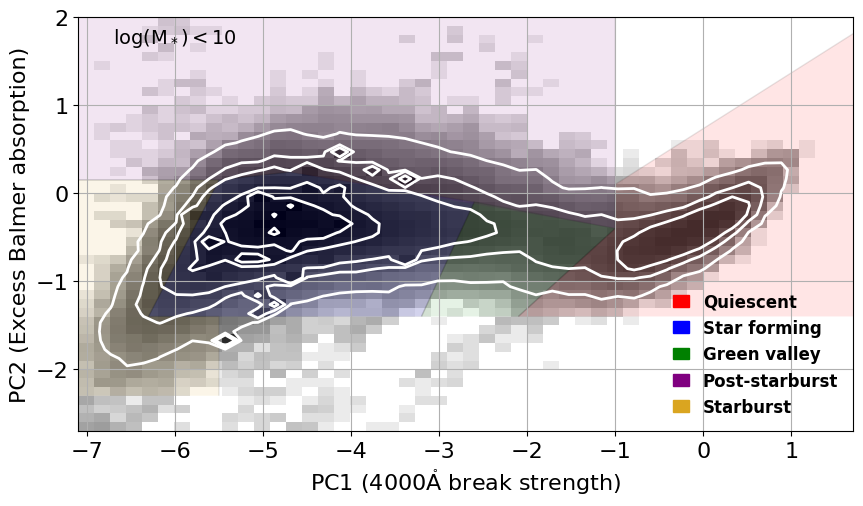

In [12]:
#PCA classification of spaxels. points needs to be a (ngal, 2) array

good_spx = spaxel_properties_master['snr_4000A_store']>10.
points = np.stack((spaxel_properties_master['pc1_store'][good_spx], \
                   -spaxel_properties_master['pc2_store'][good_spx]), axis=1) #Flip PC2

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

#low mass
counts, xedges, yedges = np.histogram2d(points[:,0][np.where((spaxel_properties_master['mstar_store'][good_spx] > 8.) & \
                                             (spaxel_properties_master['mstar_store'][good_spx] < 10.))],                                                 
                                        points[:,1][np.where((spaxel_properties_master['mstar_store'][good_spx] > 8.) & \
                                              (spaxel_properties_master['mstar_store'][good_spx] < 10.))], \
                                        bins=50, range=[[-7.1, 2.0], [-3., 2.]])

levels = [np.amax(counts)*0.01, np.amax(counts)*0.05, np.amax(counts)*0.1, np.amax(counts)*0.3, \
          np.amax(counts)*0.5, np.amax(counts)*0.9]

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

ax.imshow(np.log10(counts).T, extent=extent, origin='lower', cmap='gray_r')

ax.contour(counts.T, levels, extent=extent, linewidths=2, colors='white', linestyles='solid')

with open(dir+'OUTPUT/contours_lowmass_'+release+'.pkl','wb') as f:
    pickle.dump([counts, levels, extent], f)

ax.set_xlim(-7.1, 1.7)
ax.set_ylim(-2.7, 2.)
ax.set_xlabel('PC1 ($4000\\mathrm{\\mathring{A}}$ break strength)', fontsize=16)
ax.set_ylabel('PC2 (Excess Balmer absorption)', fontsize=16)
plt.grid('off')


#result = vwPca.PCA_classify(points, vertices_lowmass)

# SF
sf_verts = [
    (vertices_lowmass['sf_vert1'], vertices_lowmass['junk_y_lower']), # left, bottom
    (vertices_lowmass['sf_vert2'], vertices_lowmass['sb_cut']), # left, top
    (vertices_lowmass['psb_peak_x'], vertices_lowmass['psb_cut']), # center, top
    (vertices_lowmass['sf_vert3'], vertices_lowmass['psb_cut3']), # top, right
    (vertices_lowmass['sf_vert4'], vertices_lowmass['junk_y_lower']) # right, bottom
    ]

sf_path = Path(sf_verts)
#SF = sf_path.contains_points(points)

# PSB
psb_verts = [
    (vertices_lowmass['psb_peak_x'], vertices_lowmass['psb_cut']), # center, top
    (vertices_lowmass['sf_vert2'], vertices_lowmass['sb_cut']), # right, top
    (vertices_lowmass['left_cut'], vertices_lowmass['sb_cut']), # left, bottom
    (vertices_lowmass['left_cut'], vertices_lowmass['junk_y_upper']), # left, top
    (vertices_lowmass['green_vert1'], vertices_lowmass['junk_y_upper']), # right, top
    (vertices_lowmass['green_vert1'], vertices_lowmass['psb_cut2']) # right, bottom
    ]

psb_path = Path(psb_verts)
#PSB = psb_path.contains_points(points)

# SB
sb_verts = [
    (vertices_lowmass['left_cut'], vertices_lowmass['sb_vert1']), # left, bottom
    (vertices_lowmass['left_cut'], vertices_lowmass['sb_cut']), # left, top
    (vertices_lowmass['sf_vert2'], vertices_lowmass['sb_cut']), # right, top
    (vertices_lowmass['sf_vert1'], vertices_lowmass['junk_y_lower']), # right, bottom
    (vertices_lowmass['sf_vert2'], vertices_lowmass['junk_y_lower']), # right, bottom
    (vertices_lowmass['sf_vert2'], vertices_lowmass['sb_vert1']) # right, bottom
    ]

sb_path = Path(sb_verts)
#SB = sb_path.contains_points(points)

# Green valley
green_verts = [
    (vertices_lowmass['sf_vert4'], vertices_lowmass['junk_y_lower']), # left, bottom
    (vertices_lowmass['sf_vert3'], vertices_lowmass['psb_cut3']), # left, top
    (vertices_lowmass['green_vert1'], vertices_lowmass['psb_cut2']), # right, top
    (vertices_lowmass['green_vert2'], vertices_lowmass['junk_y_lower']) # right, bottom
    ]

green_path = Path(green_verts)
#Green = green_path.contains_points(points)

# Red
red_verts = [
    (vertices_lowmass['green_vert2'], vertices_lowmass['junk_y_lower']), # left, bottom
    (vertices_lowmass['green_vert1'], vertices_lowmass['psb_cut2']), # left, mid
    (vertices_lowmass['green_vert1'], vertices_lowmass['psb_cut2']+0.5), # left, top
    (vertices_lowmass['right_cut'], vertices_lowmass['junk_y_upper']), # right, top
    (vertices_lowmass['right_cut'], vertices_lowmass['junk_y_lower']) # right, bottom
    ]

red_path = Path(red_verts)
#Red = red_path.contains_points(points)

# Junk
junk_verts = [
    (vertices_lowmass['sf_vert2'], vertices_lowmass['junk_y_lower2']), # left, bottom
    (vertices_lowmass['sf_vert2'], vertices_lowmass['junk_y_lower']), # left, top
    (vertices_lowmass['right_cut'], vertices_lowmass['junk_y_lower']), # right, top
    (vertices_lowmass['right_cut'], vertices_lowmass['junk_y_lower2']) # right, bottom
    ]

junk_path = Path(junk_verts)
#Junk = junk_path.contains_points(points)

sf_patch = patches.PathPatch(sf_path, facecolor='blue', alpha=0.1)
ax.add_patch(sf_patch)

psb_patch = patches.PathPatch(psb_path, facecolor='purple', alpha=0.1)
ax.add_patch(psb_patch)

sb_patch = patches.PathPatch(sb_path, facecolor='goldenrod', alpha=0.1)
ax.add_patch(sb_patch)

green_patch = patches.PathPatch(green_path, facecolor='green', alpha=0.1)
ax.add_patch(green_patch)

red_patch = patches.PathPatch(red_path, facecolor='red', alpha=0.1)
ax.add_patch(red_patch)

ax.text(-6., 1.7, '$\mathrm{log(M}_*)<10$', horizontalalignment='center', fontsize=14)

red_patch = patches.Patch(color='red', label='Quiescent')
blue_patch = patches.Patch(color='blue', label='Star forming')
green_patch = patches.Patch(color='green', label='Green valley')
purple_patch = patches.Patch(color='purple', label='Post-starburst')
yellow_patch = patches.Patch(color='goldenrod', label='Starburst')

plt.legend(handles=[red_patch, blue_patch, green_patch, purple_patch, yellow_patch], loc=4, \
           frameon=0, handlelength=1, numpoints=1, prop={'size':12, 'weight':'bold'})
    
plt.savefig(fig_dir+'PC12_MaNGA_spaxels_lowmass.pdf', bbox_inches='tight')
plt.show()

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)


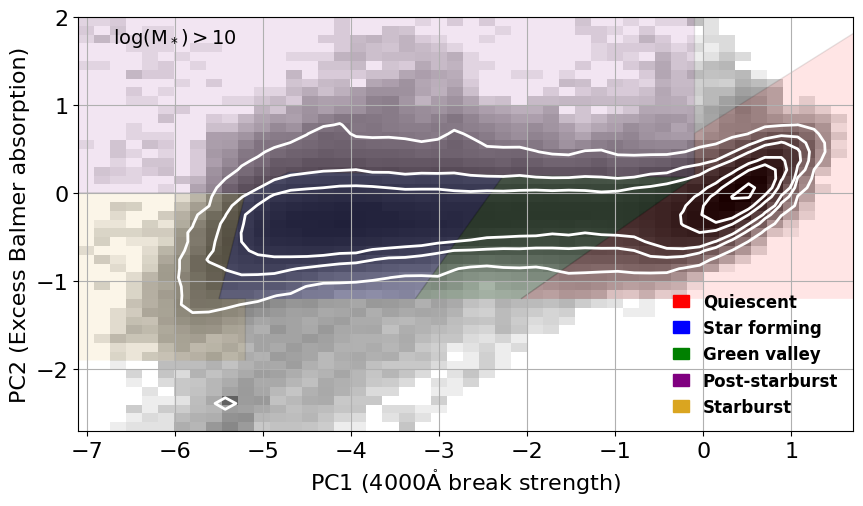

In [13]:
#PCA classification of spaxels. points needs to be a (ngal, 2) array

good_spx = spaxel_properties_master['snr_4000A_store']>10.
points = np.stack((spaxel_properties_master['pc1_store'][good_spx], \
                   -spaxel_properties_master['pc2_store'][good_spx]), axis=1) #Flip PC2

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

#low mass
counts, xedges, yedges = np.histogram2d(points[:,0][np.where((spaxel_properties_master['mstar_store'][good_spx] > 10.) & \
                                             (spaxel_properties_master['mstar_store'][good_spx] < 12.))],                                                 
                                        points[:,1][np.where((spaxel_properties_master['mstar_store'][good_spx] > 10.) & \
                                              (spaxel_properties_master['mstar_store'][good_spx] < 12.))], \
                                        bins=50, range=[[-7.1, 2.0], [-3., 2.]])

levels = [np.amax(counts)*0.01, np.amax(counts)*0.05, np.amax(counts)*0.1, np.amax(counts)*0.3, \
          np.amax(counts)*0.5, np.amax(counts)*0.9]

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

ax.imshow(np.log10(counts).T, extent=extent, origin='lower', cmap='gray_r')

ax.contour(counts.T, levels, extent=extent,linewidths=2, colors='white', linestyles='solid')

with open(dir+'OUTPUT/contours_highmass_'+release+'.pkl','wb') as f:
    pickle.dump([counts, levels, extent], f)

ax.set_xlim(-7.1, 1.7)
ax.set_ylim(-2.7, 2.)
ax.set_xlabel('PC1 ($4000\\mathrm{\\mathring{A}}$ break strength)', fontsize=16)
ax.set_ylabel('PC2 (Excess Balmer absorption)', fontsize=16)
plt.grid('off')


#result = vwPca.PCA_classify(points, vertices_highmass)

# SF
sf_verts = [
    (vertices_highmass['sf_vert1'], vertices_highmass['junk_y_lower']), # left, bottom
    (vertices_highmass['sf_vert2'], vertices_highmass['sb_cut']), # left, top
    (vertices_highmass['psb_peak_x'], vertices_highmass['psb_cut']), # center, top
    (vertices_highmass['sf_vert3'], vertices_highmass['psb_cut3']), # top, right
    (vertices_highmass['sf_vert4'], vertices_highmass['junk_y_lower']) # right, bottom
    ]

sf_path = Path(sf_verts)
#SF = sf_path.contains_points(points)

# PSB
psb_verts = [
    (vertices_highmass['psb_peak_x'], vertices_highmass['psb_cut']), # center, top
    (vertices_highmass['sf_vert2'], vertices_highmass['sb_cut']), # right, top
    (vertices_highmass['left_cut'], vertices_highmass['sb_cut']), # left, bottom
    (vertices_highmass['left_cut'], vertices_highmass['junk_y_upper']), # left, top
    (vertices_highmass['green_vert1'], vertices_highmass['junk_y_upper']), # right, top
    (vertices_highmass['green_vert1'], vertices_highmass['psb_cut2']) # right, bottom
    ]

psb_path = Path(psb_verts)
#PSB = psb_path.contains_points(points)

# SB
sb_verts = [
    (vertices_highmass['left_cut'], vertices_highmass['sb_vert1']), # left, bottom
    (vertices_highmass['left_cut'], vertices_highmass['sb_cut']), # left, top
    (vertices_highmass['sf_vert2'], vertices_highmass['sb_cut']), # right, top
    (vertices_highmass['sf_vert1'], vertices_highmass['junk_y_lower']), # right, bottom
    (vertices_highmass['sf_vert2'], vertices_highmass['junk_y_lower']), # right, bottom
    (vertices_highmass['sf_vert2'], vertices_highmass['sb_vert1']) # right, bottom
    ]

sb_path = Path(sb_verts)
#SB = sb_path.contains_points(points)

# Green valley
green_verts = [
    (vertices_highmass['sf_vert4'], vertices_highmass['junk_y_lower']), # left, bottom
    (vertices_highmass['sf_vert3'], vertices_highmass['psb_cut3']), # left, top
    (vertices_highmass['green_vert1'], vertices_highmass['psb_cut2']), # right, top
    (vertices_highmass['green_vert2'], vertices_highmass['junk_y_lower']) # right, bottom
    ]

green_path = Path(green_verts)
#Green = green_path.contains_points(points)

# Red
red_verts = [
    (vertices_highmass['green_vert2'], vertices_highmass['junk_y_lower']), # left, bottom
    (vertices_highmass['green_vert1'], vertices_highmass['psb_cut2']), # left, mid
    (vertices_highmass['green_vert1'], vertices_highmass['psb_cut2']+0.5), # left, top
    (vertices_highmass['right_cut'], vertices_highmass['junk_y_upper']), # right, top
    (vertices_highmass['right_cut'], vertices_highmass['junk_y_lower']) # right, bottom
    ]

red_path = Path(red_verts)
#Red = red_path.contains_points(points)

# Junk
junk_verts = [
    (vertices_highmass['sf_vert2'], vertices_highmass['junk_y_lower2']), # left, bottom
    (vertices_highmass['sf_vert2'], vertices_highmass['junk_y_lower']), # left, top
    (vertices_highmass['right_cut'], vertices_highmass['junk_y_lower']), # right, top
    (vertices_highmass['right_cut'], vertices_highmass['junk_y_lower2']) # right, bottom
    ]

junk_path = Path(junk_verts)
#Junk = junk_path.contains_points(points)

sf_patch = patches.PathPatch(sf_path, facecolor='blue', alpha=0.1)
ax.add_patch(sf_patch)

psb_patch = patches.PathPatch(psb_path, facecolor='purple', alpha=0.1)
ax.add_patch(psb_patch)

sb_patch = patches.PathPatch(sb_path, facecolor='goldenrod', alpha=0.1)
ax.add_patch(sb_patch)

green_patch = patches.PathPatch(green_path, facecolor='green', alpha=0.1)
ax.add_patch(green_patch)

red_patch = patches.PathPatch(red_path, facecolor='red', alpha=0.1)
ax.add_patch(red_patch)

ax.text(-6., 1.7, '$\mathrm{log(M}_*)>10$', horizontalalignment='center', fontsize=14)

red_patch = patches.Patch(color='red', label='Quiescent')
blue_patch = patches.Patch(color='blue', label='Star forming')
green_patch = patches.Patch(color='green', label='Green valley')
purple_patch = patches.Patch(color='purple', label='Post-starburst')
yellow_patch = patches.Patch(color='goldenrod', label='Starburst')

plt.legend(handles=[red_patch, blue_patch, green_patch, purple_patch, yellow_patch], loc=4, \
           frameon=0, handlelength=1, numpoints=1, prop={'size':12, 'weight':'bold'})
    
plt.savefig(fig_dir+'PC12_MaNGA_spaxels_highmass.pdf', bbox_inches='tight')
plt.show()